<a href="https://colab.research.google.com/github/samarth2015/writing_assignment/blob/main/Road_safety.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Group members:**

- Praanshu Patel (23110249)
- Samarth Sonawane (23110317)
- Akshat Shah (23110293)

## Data Loading:

In [20]:
# Loading the dataset (Making a pandas Dataframe with each row as a country)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Important data in each file:
# Type of data: (col 2)
# - Global loctation (eg-Africa, East Mediterranean, etc.) (col 4: code and col 5: name)
# - Country name (col 7: code and col 8: name)
# Data value (col 30)
# Extra data if present: (col 12: type of data, col 13: data)
# Year of data (col 10)

# Function to load and process the dataset
def load_dataset(file_path):
    # Read the dataset
    df = pd.read_csv(file_path, encoding='UTF-8')

    # Select relevant columns and rename them
    df = df.iloc[:, [1, 3, 4, 6, 7, 9, 11, 12, 29]]
    df.columns = ['Type', 'Global_Location_Code', 'Global_Location_Name',
                  'Country_Code', 'Country_Name', 'Year', 'Data_Type', 'Data_Description', 'Value']


    # Convert Data_Type and Data_Description to '-' if they are NaN
    df['Data_Type'] = df['Data_Type'].fillna('-')
    df['Data_Description'] = df['Data_Description'].fillna('-')

    return df


In [21]:
# Folder containing the dataset files
folder_path = '/content/'

# Loading all the datasets in the folder
import os

files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
files.sort()
dataframes = []
for file in files:
    file_path = os.path.join(folder_path, file)
    df = load_dataset(file_path)
    dataframes.append(df)
    # display(df.head())  # Display the first few rows of each dataframe

## Get summary of any country using

In [36]:
# merge all the dfs
df = pd.concat(dataframes, ignore_index=True)
# save the data in csv file
df.to_csv('merged_dataset.csv', index=False)

In [34]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.1 MB/s eta 0:00:00


In [37]:
import gradio as gr

df = pd.read_csv("merged_dataset.csv")

def get_road_safety_profile(selected_country):
    country_data = df[df['Country_Name'] == selected_country]

    # === Section 1: Road Safety Snapshot ===
    metrics_to_display = [
        "Existence of a national road safety strategy",
        "Existence of a road safety lead agency",
        "Availability of funding for national road safety strategy",
        "Existence of national speed limits",
        "Existence of a national seat-belt law",
        "Existence of a national drink-driving law",
        "Existence of a national child-restraint law"
    ]

    snapshot = ""
    for indicator in metrics_to_display:
        val = country_data[country_data['Type'] == indicator]['Value'].values
        val = val[0] if len(val) > 0 and val[0] != "-" else "No data"
        snapshot += f"**{indicator}**: {val}\n\n"

    # === Section 2: Seat-belt Wearing Rate ===
    seatbelt_df = country_data[country_data['Type'] == 'Seat-belt wearing rate (%)']
    seatbelt_str = ""
    if not seatbelt_df.empty:
        for i, row in seatbelt_df.iterrows():
            seatbelt_str += f"**{row['Data_Description']}**: {row['Value']}%\n\n"
    else:
        seatbelt_str = "No seat-belt wearing data available."

    # === Section 3: Road User Death Distribution ===
    death_dist = country_data[country_data['Type'] ==
        "Distribution of road traffic deaths by type of road user (%)"]

    fig = None
    if not death_dist.empty:
        pie_df = death_dist[['Data_Description', 'Value']].copy()
        pie_df.columns = ['Road User Type', 'Percentage']
        pie_df['Percentage'] = pie_df['Percentage'].str.replace('%', '').astype(float) / 100
        fig = px.pie(pie_df, names='Road User Type', values='Percentage',
                     title='Road Traffic Deaths by Road User Type')

    # === Section 4: Speed & BAC Limits ===
    speed_limits = country_data[country_data['Type'] == "Maximum speed limits"]
    bac_limits = country_data[country_data['Type'] == "Blood Alcohol Concentration (BAC) limit for drivers"]

    speed_str = ""
    for _, row in speed_limits.iterrows():
        val = row['Value'] if row['Value'] != '?' else "No Data"
        speed_str += f"**{row['Data_Description']}**: {val} km/h\n\n"

    bac_str = ""
    for _, row in bac_limits.iterrows():
        val = row['Value'] if row['Value'] != '-' else "No Data"
        bac_str += f"**{row['Data_Description']}**: {val}\n\n"

    # === Section 5: Estimated Deaths ===
    death_est = country_data[country_data['Type'].str.contains("Estimated number of road traffic deaths")]
    death_rate = country_data[country_data['Type'].str.contains("death rate")]

    est_deaths = death_est['Value'].values[0] if not death_est.empty else "No data"
    est_rate = death_rate['Value'].values[0] if not death_rate.empty else "No data"

    deaths_summary = f"**Estimated Deaths**: {est_deaths}\n\n**Death Rate (per 100,000)**: {est_rate}"

    # === Final Display ===
    final_display = f"""
# 🛣️ Road Safety Profile: {selected_country}

### 📊 Snapshot
{snapshot}

### 🚗 Seatbelt Wearing Rate
{seatbelt_str}

### 🧪 Speed & Alcohol Limits
#### Speed Limits
{speed_str}
#### BAC Limits
{bac_str}

### ☠️ Estimated Deaths
{deaths_summary}

---
_Data Source: WHO Road Safety Global Status Report_
    """

    return final_display, fig

# Set up Gradio interface
demo = gr.Interface(
    fn=get_road_safety_profile,
    inputs=gr.Dropdown(choices=sorted(df['Country_Name'].unique()), label="Select Country"),
    outputs=[
        gr.Markdown(label="Country Road Safety Summary"),
        gr.Plot(label="Death Distribution Pie Chart")
    ],
    title="🌍 WHO Road Safety Dashboard",
    description="Select a country to see road safety profile and key metrics.",
    theme="default"
)

demo.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0e126bce936010bafb.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
from IPython.display import IFrame
import subprocess
import time

# Run the Streamlit app
subprocess.Popen(["streamlit", "run", "app.py"])

# Give Streamlit a few seconds to start
time.sleep(5)

# Display inside notebook (port must match the one Streamlit uses)
IFrame(src='http://localhost:8501', width=1200, height=720)


In [4]:
import plotly.express as px

In [26]:
df_death_rate = dataframes[8]
type(df_death_rate["Value"][0])

numpy.float64

In [27]:
# Drop NaNs and reset index
df_death_rate.dropna(subset=['Value'], inplace=True)
df_death_rate.reset_index(drop=True, inplace=True)


In [29]:
pivot_table = df_death_rate.pivot_table(
    index=['Country_Code', 'Country_Name'],
    values='Value',
    aggfunc='mean'
).reset_index()

fig = px.choropleth(
    pivot_table,
    locations='Country_Code',
    locationmode='ISO-3',
    color='Value',
    hover_name='Country_Name',
    title='Estimated Road Traffic Death Rate (per 100,000 population)',
    color_continuous_scale=px.colors.sequential.Plasma,
    labels={'Value': 'Death Rate'}
)

fig.update_geos(projection_type='natural earth')
fig.update_layout(title_x=0.5)
fig.show()

## Helmet and seatbelt laws (and their enforcement) with motorcycle-related road traffic deaths.

### Are Road Safety Laws strictly implemented?

Every year, over a million lives are lost due to road crashes. But behind these numbers lies a critical question:

**Do laws actually save lives, or are they just ink on paper?**

In this notebook, we explore two key questions:
1. How strict are helmet and seatbelt laws across countries?
2. Are stronger laws associated with fewer deaths among motorcyclists?

Let's find out.


In [4]:

helmet_laws = dataframes[0]
helmet_fastened = dataframes[-4]
seatbelt_laws = dataframes[1]
national_seatbelt_law = dataframes[-6]
death_distribution = dataframes[6]


To begin, we explore the legal landscape:

- Which countries require helmets for all motorcycle users?
- Are helmets legally required to be fastened?
- What about rear seatbelt laws?

In [5]:
# Filter for adult passengers and drivers
helmet_all = helmet_laws[helmet_laws['Data_Description'].isin(['Drivers', 'Adult passengers'])]

# Count countries that have helmet laws for both
helmet_status = helmet_all.groupby('Country_Code')['Value'].apply(lambda x: all(val == 'Yes' for val in x)).reset_index()
helmet_status.columns = ['Country_Code', 'Helmet_Law_All_Occupants']
helmet_status['Helmet_Law_All_Occupants'] = helmet_status['Helmet_Law_All_Occupants'].astype(int)  # 1 = Yes, 0 = No

helmet_status.head()


,Country_Code,Helmet_Law_All_Occupants
0,AFG,0
1,AGO,1
2,ALB,1
3,ARE,1
4,ARG,1


In [6]:
helmet_fastened['Helmet_Fastened'] = helmet_fastened['Value'].apply(lambda x: 1 if x.strip().lower() == 'yes' else 0)
helmet_fastened = helmet_fastened[['Country_Code', 'Helmet_Fastened']]
helmet_fastened.head()


,Country_Code,Helmet_Fastened
0,AFG,0
1,ATG,0
2,COM,0
3,DMA,0
4,GUY,0


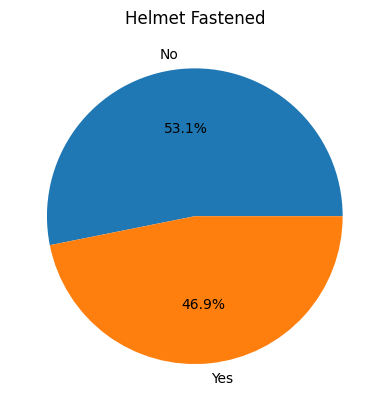

In [7]:
plt.pie(helmet_fastened['Helmet_Fastened'].value_counts(), labels=['No', 'Yes'], autopct='%1.1f%%')
plt.title('Helmet Fastened')
plt.show()

In [8]:
helmet_data = pd.merge(helmet_status, helmet_fastened, on='Country_Code', how='inner')
helmet_data.head()


,Country_Code,Helmet_Law_All_Occupants,Helmet_Fastened
0,AFG,0,0
1,AGO,1,1
2,ALB,1,0
3,ARE,1,0
4,ARG,1,1


#### Insight: Strictness of Helmet Laws

We define a country as having a **strict helmet law** if it:
- Applies to both drivers and adult passengers, AND
- Requires helmets to be fastened.


In [9]:
helmet_data["Strict_Helmet_Law"] = helmet_data.apply(
    lambda row: 1 if row["Helmet_Law_All_Occupants"] == 1 and row["Helmet_Fastened"] == 1 else 0, axis=1
)
helmet_data.head()

,Country_Code,Helmet_Law_All_Occupants,Helmet_Fastened,Strict_Helmet_Law
0,AFG,0,0,0
1,AGO,1,1,1
2,ALB,1,0,0
3,ARE,1,0,0
4,ARG,1,1,1


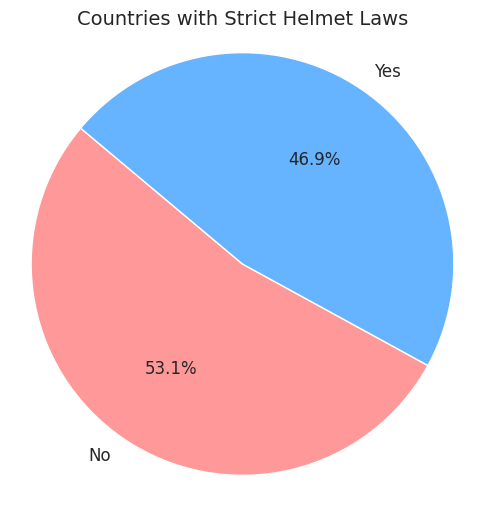

In [10]:
# Optional: apply seaborn style
sns.set_theme(style="whitegrid")

# Count values
helmet_counts = helmet_data['Strict_Helmet_Law'].value_counts().sort_index()

# Labels and colors
labels = ['No', 'Yes']
colors = ['#ff9999', '#66b3ff']

# Plot
plt.figure(figsize=(6, 6))
plt.pie(
    helmet_counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops={'fontsize': 12}
)

plt.title("Countries with Strict Helmet Laws", fontsize=14)
plt.axis('equal')  # Equal aspect ratio ensures pie is circular
plt.show()


### Do Laws Work?

Let’s now explore the link between the laws and actual motorcycle-related fatalities.

We'll use the % of road traffic deaths that are motorcyclists as a proxy for vulnerability.


In [11]:
moto_deaths = death_distribution[death_distribution['Data_Description'] == 'Drivers/passengers of motorized 2- or 3-wheelers']
moto_deaths = moto_deaths[['Country_Code', 'Value']]
moto_deaths.columns = ['Country_Code', 'Motorcyclist_Death_Percentage']
moto_deaths['Motorcyclist_Death_Percentage'] = pd.to_numeric(moto_deaths['Motorcyclist_Death_Percentage'], errors='coerce')


In [12]:
moto_deaths

,Country_Code,Motorcyclist_Death_Percentage
1,ATG,0.0
4,BWA,0.0
11,DMA,0.0
16,JOR,0.0
30,FSM,0.0
...,...,...
633,SWZ,2.0
637,NIC,26.0
648,AND,50.0
653,MHL,66.7


In [13]:
law_vs_deaths = pd.merge(helmet_data, moto_deaths, on='Country_Code', how='inner')
law_vs_deaths.dropna(inplace=True)

law_vs_deaths.head()


,Country_Code,Helmet_Law_All_Occupants,Helmet_Fastened,Strict_Helmet_Law,Motorcyclist_Death_Percentage
0,ALB,1,0,0,11.9
1,ARE,1,0,0,5.5
2,ARG,1,1,1,22.2
3,ARM,1,1,1,1.5
4,ATG,0,0,0,0.0


In [15]:
law_vs_deaths['Strict_Helmet_Law_Label'] = law_vs_deaths['Strict_Helmet_Law'].map({0: 'No Strict Law', 1: 'Strict Law'})

fig = px.box(
    law_vs_deaths,
    x='Strict_Helmet_Law_Label',
    y='Motorcyclist_Death_Percentage',
    color='Strict_Helmet_Law_Label',
    color_discrete_map={'No Strict Law': '#ff9999', 'Strict Law': '#66b3ff'},
    points="all",
    hover_data=['Country_Code']
)

fig.update_layout(
    title="Motorcyclist Deaths vs. Strict Helmet Laws",
    xaxis_title="Strict Helmet Law",
    yaxis_title="Motorcyclist Deaths (% of total)",
    showlegend=False,
    template="plotly_white"
)

fig.show()


In [16]:
# Prepare data
sunburst_df = helmet_data.copy()
sunburst_df['Strict_Helmet_Law_Label'] = sunburst_df['Strict_Helmet_Law'].map({1: 'Strict Law', 0: 'No Strict Law'})

# Fill missing region if needed
sunburst_df = sunburst_df.dropna(subset=['Country_Code'])

# Plot sunburst
fig = px.sunburst(
    sunburst_df,
    path=['Strict_Helmet_Law_Label', 'Helmet_Fastened', 'Country_Code'],
    values=None,
    color='Strict_Helmet_Law_Label',
    color_discrete_map={'Strict Law': '#66b3ff', 'No Strict Law': '#ff9999'},
    title="Layers of Helmet Safety Laws Across Regions",
    width=700,
    height=600
)

fig.update_traces(textinfo='label+percent entry')
fig.show()


In [17]:
fig = px.scatter(
    law_vs_deaths,
    x='Strict_Helmet_Law',
    y='Motorcyclist_Death_Percentage',
    color='Strict_Helmet_Law',
    text='Country_Code',
    color_discrete_map={1: '#66b3ff', 0: '#ff9999'},
    title='Motorcyclist Death % vs Helmet Law Strictness'
)

fig.update_traces(textposition='top center')
fig.update_layout(
    xaxis=dict(tickvals=[0, 1], ticktext=["No Strict Law", "Strict Law"]),
    yaxis_title="Motorcyclist Death Percentage"
)
fig.show()


#### Poor enforcement of laws

**Countries below have the more than 40% of motorcyclist deaths despite of having strict laws**
- THA - Thailand
- MMR - Myanmar
- BEN - Benin
- PRY - Paraguay
- SUR - Suriname
- SGP - Singapore
- MLI - Mali
- IND - India

### Alcohol Inferences:


In [18]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
# World map using chloropleth for % deaths due to alcohol in each country/region

import plotly.express as px
import pandas as pd

# Load the dataset
df = pd.read_csv('merged_dataset.csv')

# Relevant values in 'Type' column:
# Attribution of deaths to alcohol
# Estimated number of road traffic deaths
# We will use only the rows with both and calculate the percentage of deaths due to alcohol for each country/region

# Filter the dataset for relevant types
dfe = df[df['Type'].isin(['Estimated number of road traffic deaths'])]
dfe.reset_index(drop=True, inplace=True)

# The data in 'Value' for Estimated number of road traffic deaths is in the form 10 [8-12] i.e. average [low-high]
# We need to convert this to a numeric value for calculations
def extract_value(value):
    if '[' in value:
        # Extract the average value from the range
        if "[" in value:
            avg_value = value.split('[')[0].strip()
            # Remove any spaces or commas
            avg_value = avg_value.replace(' ', '').replace(',', '')
            # Convert to float
            avg_value = float(avg_value)
        else:
            avg_value = float(value)
        return avg_value
    else:
        return float(value)

# Apply the function to the 'Estimated number of road traffic deaths' values
dfe['Value'] = dfe['Value'].apply(extract_value)
#display(dfe.head())

# Create a pivot table to get the values for each country/region
pivot_table_e = dfe.pivot_table(index=['Country_Code', 'Country_Name'], columns='Type', values='Value', aggfunc='mean').reset_index()

display(pivot_table_e.head())  # Display the first few rows of the pivot table

Type,Country_Code,Country_Name,Estimated number of road traffic deaths
0,AFG,Afghanistan,9684.0
1,AGO,Angola,5188.0
2,ALB,Albania,309.0
3,AND,Andorra,2.0
4,ARE,United Arab Emirates,557.0


In [20]:
# The percentage of deaths due to alcohol is given in the 'Attribution of deaths to alcohol' column
# We will use this to calculate the percentage of deaths due to alcohol for each country/region
import numpy as np

# Filter the dataset for relevant types
dfap = df[df['Type'].isin(['Attribution of road traffic deaths to alcohol (%)'])]

# Convert the 'Value' column to numeric values and handling exceptions that contain some letters
# The rest of the data is a float value in a string format (there is no range like previously)

def extract_value(value):
    if value=='–':
        value = np.nan
    else:
        value = float(value.split(' ')[0])
    return value

dfap['Value'] = dfap['Value'].apply(extract_value)
# Drop nan
dfap.dropna(subset=['Value'], inplace=True)
# reset index
dfap.reset_index(drop=True, inplace=True)
#display(dfap.head())

# Create a pivot table to get the values for each country/region
pivot_table_ap = dfap.pivot_table(index=['Country_Code', 'Country_Name'], columns='Type', values='Value', aggfunc='mean').reset_index()
#display(pivot_table_ap.head())  # Display the first few rows of the pivot table

# Make the world map using plotly express
fig = px.choropleth(pivot_table_ap,
                    locations='Country_Code',
                    locationmode='ISO-3',
                    color='Attribution of road traffic deaths to alcohol (%)',
                    hover_name='Country_Name',
                    title='Percentage of Road Traffic Deaths Attributed to Alcohol by Country/Region',
                    color_continuous_scale=px.colors.sequential.Plasma,
                    labels={'Attribution of road traffic deaths to alcohol (%)': 'Percentage of Deaths Due to Alcohol'}
                   )
fig.update_geos(projection_type='natural earth')
fig.update_layout(title_x=0.5)  # Center the title

fig.show()

In [21]:
# Bubble chart:
#X-axis: BAC limit (lower = stricter)
#Y-axis: % of deaths due to alcohol
#Size: total traffic deaths
#Color: Country

import plotly.express as px
import pandas as pd
import numpy as np

# Using % deaths due to alcohol from the previous dfap dataframe
# Using size of total traffic deaths from the dfe dataframe

# Using BAC limit from the df dataframe
# Filter the dataset for relevant types
dfbac = df[df['Type'].isin(['Blood Alcohol Concentration (BAC) limit for drivers'])]
# The data is in the form: - if there is no limit
# Of the form <0.05 g/dl if there is a limit (< can also be <=)
# There is no < or <= if limit is 0 g/dl
# Some are of the form: 0.00 - 0.08 g/dl

# We will use the upper limit for the BAC limit

def extract_value(value):
    if value == '-':
        value = np.nan
    elif '=' in value:
        value = value.split('=')[1].strip()
        value = value.replace('g/dl', '').replace(' ', '').replace(',', '')
    elif '<' in value:
        value = value.split('<')[1].strip()
        value = value.replace('g/dl', '').replace(' ', '').replace(',', '')
    elif '-' in value:
        value = value.split('-')[1].strip()
        value = value.replace('g/dl', '').replace(' ', '').replace(',', '')
    else:
        value = value.split(' ')[0].strip()
        value = value.replace('g/dl', '').replace(' ', '').replace(',', '')

    return float(value)

# Apply the function to the 'Blood Alcohol Concentration (BAC) limit for drivers' values
dfbac['Value'] = dfbac['Value'].apply(extract_value)
# Drop nan
dfbac.dropna(subset=['Value'], inplace=True)
# reset index
dfbac.reset_index(drop=True, inplace=True)
#display(dfbac.head())

# Create a pivot table to get the values for each country/region
pivot_table_bac = dfbac.pivot_table(index=['Country_Code', 'Country_Name'], columns='Type', values='Value', aggfunc='mean').reset_index()
#display(pivot_table_bac.head())  # Display the first few rows of the pivot table

# Merge the dataframes to get the BAC limit, % deaths due to alcohol and total traffic deaths in one dataframe
# Merge the dataframes on Country_Code and Country_Name

merged_df = pd.merge(pivot_table_ap, pivot_table_bac, on=['Country_Code', 'Country_Name'], how='inner')
merged_df = pd.merge(merged_df, pivot_table_e, on=['Country_Code', 'Country_Name'], how='inner')
display(merged_df.head())  # Display the first few rows of the merged dataframe

# Make the bubble chart using plotly express

# scale the size of the bubbles to be more manageable
merged_df['Scaled Deaths'] = merged_df['Estimated number of road traffic deaths'] / 1000

# Sort so that large bubbles go behind
merged_df = merged_df.sort_values('Scaled Deaths', ascending=False)
fig1 = px.scatter(
    merged_df,
    x='Blood Alcohol Concentration (BAC) limit for drivers',
    y='Attribution of road traffic deaths to alcohol (%)',
    #size='Scaled Deaths',  # scaled size
    color='Country_Name',  # each country gets a unique color
    hover_name='Country_Name',
    title='Bubble Chart: BAC Limit vs % Deaths Due to Alcohol',
    labels={
        'Blood Alcohol Concentration (BAC) limit for drivers': 'BAC Limit (g/dl)',
        'Attribution of road traffic deaths to alcohol (%)': 'Percentage of Deaths Due to Alcohol'
    },
    size_max=30,  # reduce max size
    height=600,
)

fig1.update_traces(marker=dict(sizemode='diameter', opacity=0.7, line_width=1))
fig1.update_layout(
    title_x=0.5,
    legend_title_text='Country',
    showlegend=True  # set True if you want a clickable color legend
)

fig1.show()

fig = px.scatter(
    merged_df,
    x='Blood Alcohol Concentration (BAC) limit for drivers',
    y='Attribution of road traffic deaths to alcohol (%)',
    size='Scaled Deaths',  # scaled size
    color='Country_Name',  # each country gets a unique color
    hover_name='Country_Name',
    title='Bubble Chart: BAC Limit vs % Deaths Due to Alcohol (with size of bubble as Total Deaths)',
    labels={
        'Blood Alcohol Concentration (BAC) limit for drivers': 'BAC Limit (g/dl)',
        'Attribution of road traffic deaths to alcohol (%)': 'Percentage of Deaths Due to Alcohol'
    },
    size_max=30,  # reduce max size
    height=600,
)

fig.update_traces(marker=dict(sizemode='diameter', opacity=0.7, line_width=1))
fig.update_layout(
    title_x=0.5,
    legend_title_text='Country',
    showlegend=True  # set True if you want a clickable color legend
)

fig.show()

Type,Country_Code,Country_Name,Attribution of road traffic deaths to alcohol (%),Blood Alcohol Concentration (BAC) limit for drivers,Estimated number of road traffic deaths
0,ALB,Albania,5.2,0.050,309.0
1,ARE,United Arab Emirates,1.8,0.010,557.0
2,ARG,Argentina,17.0,0.050,3983.0
3,ARM,Armenia,1.9,0.040,379.0
4,AUS,Australia,17.0,0.025,1163.0


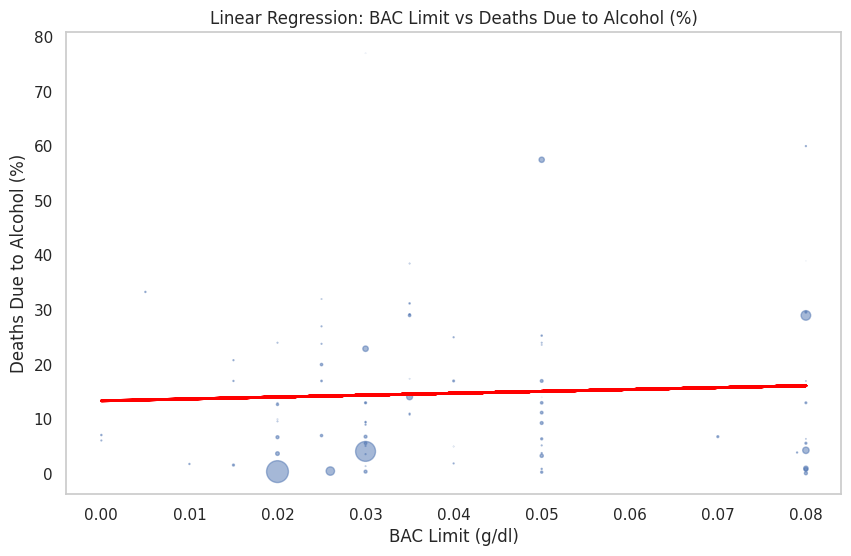

In [22]:
# regression line for the bubble chart
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Data for regression: merged_df dataframe
# X: BAC limit (g/dl)
# Y: % deaths due to alcohol
# Size: total traffic deaths (scaled)
# Color: Country
# We will use the scaled size for the regression line

# Create a new dataframe with the relevant columns
regression_df = merged_df[['Blood Alcohol Concentration (BAC) limit for drivers',
                             'Attribution of road traffic deaths to alcohol (%)',
                             'Scaled Deaths']].copy()
regression_df.rename(columns={'Blood Alcohol Concentration (BAC) limit for drivers': 'BAC Limit',
                               'Attribution of road traffic deaths to alcohol (%)': 'Deaths Due to Alcohol (%)',
                               'Scaled Deaths': 'Total Deaths'}, inplace=True)
# Drop rows with NaN values
regression_df.dropna(inplace=True)
# Reset index
regression_df.reset_index(drop=True, inplace=True)
#display(regression_df.head())

# Create a linear regression model
X = regression_df['BAC Limit']
Y = regression_df['Deaths Due to Alcohol (%)']
X = sm.add_constant(X)  # Add a constant term to the predictor

model = sm.OLS(Y, X).fit()  # Fit the model
predictions = model.predict(X)  # Make predictions

# Print the summary of the model
#print(model.summary())

# Plot the regression line
plt.figure(figsize=(10, 6))
plt.scatter(X['BAC Limit'], Y, s=regression_df['Total Deaths'], alpha=0.5)
plt.plot(X['BAC Limit'], predictions, color='red', linewidth=2)
plt.xlabel('BAC Limit (g/dl)')
plt.ylabel('Deaths Due to Alcohol (%)')
plt.title('Linear Regression: BAC Limit vs Deaths Due to Alcohol (%)')
plt.grid()
plt.show()

In [23]:
# Bar plot for Number of countries vs Availability of funding for national road safety strategy
import plotly.express as px
import pandas as pd
import numpy as np

# The data is the rows with Type: Availability of funding for national road safety strategy
# The data is in the form: - if there is no data
# the rest are in the 3 class: - Not funded, - Partially funded, - Fully funded

# We will use the number of countries in each class to make the bar plot
# Filter the dataset for relevant types
df_funding = df[df['Type'].isin(['Availability of funding for national road safety strategy'])]

def extract_value(value):
    if value == '−':
        value = np.nan
    else:
        value = value

    return value

# Apply the function to the 'Availability of funding for national road safety strategy' values
df_funding['Value'] = df_funding['Value'].apply(extract_value)
# Drop nan
df_funding.dropna(subset=['Value'], inplace=True)
# reset index
df_funding.reset_index(drop=True, inplace=True)
#display(df_funding.head())

# Bar plot for Number of countries vs Availability of funding for national road safety strategy
# Create a new dataframe with the relevant columns
funding_df = df_funding[['Country_Code', 'Country_Name', 'Value']].copy()
funding_df.rename(columns={'Value': 'Funding'}, inplace=True)

# Count the number of countries in each class
funding_count = funding_df['Funding'].value_counts().reset_index()
funding_count.columns = ['Funding', 'Count']

# Make the bar plot using plotly express
fig = px.bar(funding_count,
             x='Funding',
             y='Count',
             title='Number of Countries vs Availability of Funding for National Road Safety Strategy',
             labels={'Funding': 'Availability of Funding', 'Count': 'Number of Countries'},
             color='Funding',
             color_discrete_sequence=px.colors.qualitative.Plotly)
fig.update_layout(title_x=0.5)  # Center the title
fig.show()

# Using fig 1 but with color as funding

# Modify the dataframe to include the funding information
merged_df2 = merged_df.copy()
merged_df2 = pd.merge(merged_df2, funding_df, on=['Country_Code', 'Country_Name'], how='inner')
#display(merged_df2.head())  # Display the first few rows of the merged dataframe

fig1 = px.scatter(
    merged_df2,
    x='Blood Alcohol Concentration (BAC) limit for drivers',
    y='Attribution of road traffic deaths to alcohol (%)',
    #size='Scaled Deaths',  # scaled size
    color='Funding',  # each country gets a unique color
    hover_name='Country_Name',
    title='Bubble Chart: BAC Limit vs % Deaths Due to Alcohol (with size of bubble as Total Deaths)',
    labels={
        'Blood Alcohol Concentration (BAC) limit for drivers': 'BAC Limit (g/dl)',
        'Attribution of road traffic deaths to alcohol (%)': 'Percentage of Deaths Due to Alcohol'
    },
    size_max=30,  # reduce max size
    height=600,
)
fig1.update_traces(marker=dict(sizemode='diameter', opacity=0.7, line_width=1))
fig1.update_layout(
    title_x=0.5,
    legend_title_text='Country',
    showlegend=True  # set True if you want a clickable color legend
)
fig1.show()